Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

1. Predicting whether the label in the blueWins column is 1 or 0. In other words, whether the Blue Team wins or loses.
2. Problem is classification.
3. 2 classes. Either 1 or 0, i.e. win or loss. Aproximately 50% wins and 50% losses.
4. Just going to use accuracy since majority class frequency is equal to 50%. Checking precision and recall did not result in significantly different values than accuracy.
5. Did a random 80/20 split for train and test, and then another 80/20 split on top of train for train and validation. Thus the ratio of observations for train, valdiation, and test sets are 64%, 16%, and 20%.

In [73]:
import pandas as pd
df = pd.read_csv('../data/league-of-legends/high_diamond_ranked_10min.csv')

In [39]:
from pandas_profiling import ProfileReport
ProfileReport(df, minimal=True).to_notebook_iframe()

In [77]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""

    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # Dropping gameId column due to being unrelated to the outcome of the match
    X.drop(columns='gameId', inplace=True)
    
    # return the wrangled dataframe
    return X

In [79]:
from sklearn.model_selection import train_test_split

# Split df into train & test. 80/20 split.
target = 'blueWins'
train, test = train_test_split(df, test_size=0.20,
                               stratify=df[target], random_state=42)

# Split train into train & val. 80/20 split.
train, val = train_test_split(train, test_size=0.20,
                               stratify=train[target], random_state=42)

In [80]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [81]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [82]:
# converting target into a list to find the majority class
# using value_counts(normalize=True) to find the accuracy score
y = y_train.values.tolist()
majority_class = max(set(y), key = y.count)
print(f'Majority Class: {majority_class}')
print(f'Accuracy Score: {y_train.value_counts(normalize=True)[0]:,.2f}')

Majority Class: 0
Accuracy Score: 0.50


In [83]:
from sklearn.linear_model import LogisticRegression

# Instantiate model
log_model = LogisticRegression(random_state=42, n_jobs=-1)

In [84]:
# Fit model on training data
log_model.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=42)

In [86]:
# Check performance metric (accuracy) on train, validation, and test sets
print('Training Accuracy:', log_model.score(X_train, y_train))
print('Validating Accuracy:', log_model.score(X_val, y_val))
print('Testing Accuracy:', log_model.score(X_test, y_test))

Training Accuracy: 0.73157228725087
Validating Accuracy: 0.7318153067678684
Testing Accuracy: 0.7226720647773279


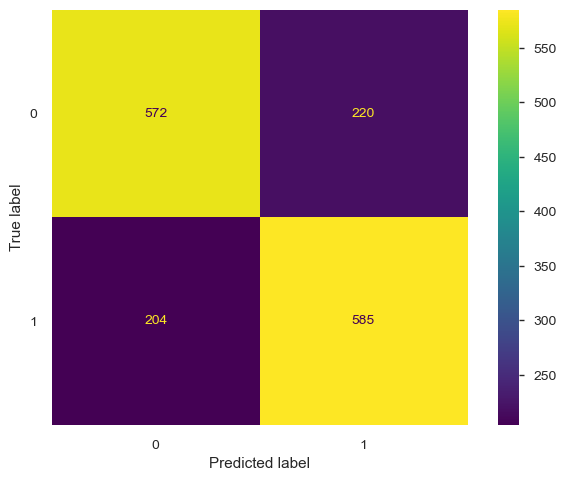

In [87]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(log_model, X_val, y_val, values_format='.0f')

In [88]:
y_pred = log_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       792
           1       0.73      0.74      0.73       789

    accuracy                           0.73      1581
   macro avg       0.73      0.73      0.73      1581
weighted avg       0.73      0.73      0.73      1581

